# Optimización de la Capacidad de Carga en Vuelos de ValpoFly

### **Presentado por: Cristian Riquelme Fernández.**

- El objetivo principal de este proyecto es maximizar el uso de la bodega de equipaje en los vuelos de ValpoFly. Para lograrlo, se busca desarrollar una solución analítica que anticipe, de manera confiable y práctica, la capacidad de carga disponible. Esta herramienta deberá proveer la información necesaria, como los detalles del vuelo y sus restricciones y equipaje por pasajeros, al área de operaciones con un mínimo de 4 horas de antelación a cada vuelo.



## Parte I – Propuesta conceptual

**1. Datos necesarios**
   - ¿Qué tipo de datos integrar para resolver este problema y cómo esos ayudan a tomar mejores decisiones?
 
Para maximizar el uso de la bodega de equipaje de manera confiable y con al menos 4 horas de anticipación, se requerirían los siguientes datos:
 
**A.Datos de Vuelos:**

- Identificador único de vuelo (id_vuelo): Para trazar toda la información asociada a un vuelo específico.

- Ruta (Origen/Destino): Puede influir en la demanda de carga y el tipo de equipaje.

- Horario salida: Esencial para aplicar la restricción de 4 horas.

**B.Características de la aeronave:**

- Capacidad máxima de la bodega en peso (kg): Restricción física fundamental.

- Capacidad máxima de la bodega en volumen (m³): La segunda restricción clave.


**C.Datos de Pasajeros:**

- Identificador único de pasajero (id_pasajero): Para asociar al pasajero con su equipaje y reserva.

- Vuelo asociado (id_vuelo): Vínculo clave entre las tablas de datos.

- Clase de la reserva (First, Business, Economy): Crítico para establecer reglas de negocio y priorización. Como se demostró en el prototipo, los pasajeros de clases superiores tienden a llevar más equipaje.

**D.Datos de Equipaje:**

- Identificador único de equipaje (id_equipaje): Para el seguimiento individual de cada maleta.

- Pasajero asociado (id_pasajero): Para vincular el equipaje a un pasajero y su clase.

- Peso real del equipaje (kg) y Volumen (m³): Las variables principales para el cálculo de la ocupación de la bodega.

Justificación: Con estos datos se puede generar reportes detallados que crucen las variables de peso y volumen para cada vuelo. Esta información permite calcular la capacidad de carga sobrante y tomar decisiones de optimización, tal como se implementa en el Índice de Potencial de Carga (IPC) del prototipo. El objetivo final es producir un reporte con todos los detalles necesarios para una rápida comprensión visual, destacando los porcentajes de ocupación total.


**2. Evaluación de pertinencia y calidad**
   - ¿Qué criterios se utilizan para decidir si un dato es útil o no?

- **Relevancia:** debe aportar a la estimación de uso de la bodega, como la cantidad de equipaje según clase y el peso de esta. Detalle más abiertos no servirían para el objetivo único que busca optimizar el modelo.


- **Exactitud y consistencia:** valores de peso y volumen deben ser medidos de manera confiable y no superar umbrales físicos. Para generar la cantidad de pasajeros y limitantes de bodega se buscó el promedio presnete en los aviones en Chile para acercarlos a la realidad práctica.*


- **Completitud:** cada pasajero debe tener su información de clase y, en caso de tener maletas, estas deben estar registradas con peso y volumen. Además, cada vuelo y pasajero deben tener sus Id propios sin duplicados, por lo que se recurre a librería 'uuid', gestora de identificadores únicos.

**3. Desarrollo de la solución**
   - Descripción de los pasos para construir el producto analítico. Explicación de cómo asegurar que los resultados estén disponibles 4 horas antes del vuelo.
   
- Primero se desarrolla un modelo heurístico (IPC) con datos sintéticos para demostrar la viabilidad del concepto y validar la lógica de negocio con el área de operaciones. Con las funciones generadas según la lógica de programación orientada a objetos, se hace posible la reproductibilidad del modelo en otros entornos e incorporarlos a pipelines que extraigan la información real desde alguna API. Así, se crea un método de limpieza, transformación y carga que se mantendría actualizado según la configuración de la limitante horaria exigida. 


- La base de datos final generada, presentada como tabla en el apartado 2, alimentaría un dashboard en tiempo real, como Power BI, para que el equipo de operaciones pueda visualizar el estado de las bodegas y tomar decisiones más rápida con indicadores claros.


- Para asegurar la disponibilidad 4 horas antes del vuelo, el script de Python se empaquetaría y se desplegaría en un entorno de producción. Se utilizaría un orquestador de tareas como Apache Airflow para programar la ejecución del pipeline. Dentro del script, se mantendría el filtro que descarta los vuelos cuya salida es en menos de 4 horas, asegurando que el reporte siempre sea relevante para la toma de decisiones.

## Parte II – Prototipo con datos sintéticos

In [88]:
# Carga de librerías 
import pandas as pd
import random
import uuid
from datetime import datetime, timedelta
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns

###  1: CREACIÓN DE DATASETS CON DATOS SINTÉTICOS REPRESENTATIVOS

- Semilla aleatoria, para reproducibilidad.
- Se generan vuelos, pasajeros y equipajes con atributos relevantes (peso, volumen, clase, etc.).
- Se incluyen capacidades de peso y volumen por vuelo.
- Creación de los datos y sus gráficas para analisis de distribución.

In [89]:
# 1.1: Configuración de constantes para la creación de los datos (pueden ser modificadas para probar resultados)
# Generales 
RANDOM_SEED = 42  # (para reproductibilidad del modelo)
HORAS_MINIMAS_ANTICIPACION = 4

# Vuelos
AEROPUERTOS_ORIGEN: List[str] = ['SCL', 'VVI', 'LIM', 'BOG', 'EZE']
AEROPUERTOS_DESTINO: List[str] = ['MIA', 'MAD', 'CDG', 'JFK', 'LAX']
CAPACIDADES_PESO_KG: List[int] = [8000, 12000, 15000]   # Limitación de bodega
CAPACIDADES_VOLUMEN_M3: List[int] = [30, 45, 60]        # Limitación de bodega

# Pasajeros
CLASES_PASAJERO: List[str] = ['Economy', 'Business', 'First']
PROBABILIDADES_CLASE: List[float] = [0.80, 0.15, 0.05]

# Equipaje 
MALETAS_POR_CLASE: Dict[str, Dict[str, Any]] = {
    'First':    {'opciones': [2, 3], 'pesos': [0.5, 0.5], 'peso_extra_kg': 5},
    'Business': {'opciones': [1, 2], 'pesos': [0.4, 0.6], 'peso_extra_kg': 3},
    'Economy':  {'opciones': [0, 1, 2], 'pesos': [0.2, 0.7, 0.1], 'peso_extra_kg': 0}
}

# 1.2: Clases y funciones modulares. Programación orientada a objetos (POO).

class CreadorDatosSinteticos:
    """
    Encapsula toda la lógica para generar, analizar y reportar el potencial
    de carga de un conjunto de vuelos.
    """
    def __init__(self, n_vuelos: int, seed: int = RANDOM_SEED):
        """
        Inicializa el analizador, fijando la semilla de aleatoriedad y
        generando el conjunto de datos base.

        Parámetros
        ----------
        n_vuelos : int
            Número de vuelos a simular.
        seed : int
            Semilla para la generación de números aleatorios para reproducibilidad.
        """
        random.seed(seed)
        self.vuelos_df: pd.DataFrame = self._generar_datos_vuelos(n_vuelos)
        self.pasajeros_df: pd.DataFrame = self._generar_datos_pasajeros()
        self.equipajes_df: pd.DataFrame = self._generar_datos_equipaje()
        print("--- Datos generados ---")
        print(f"Vuelos: {len(self.vuelos_df)}")
        print(f"Pasajeros: {len(self.pasajeros_df)}")
        print(f"Equipajes: {len(self.equipajes_df)}\n")


    def _generar_datos_vuelos(self, n_vuelos: int) -> pd.DataFrame:
        """Genera un DataFrame con datos de vuelos."""
        vuelos = []
        ahora = datetime.now()
        for _ in range(n_vuelos):
            vuelo = {
                'vuelo_id': f'VL_{uuid.uuid4().hex[:8]}',
                'origen': random.choice(AEROPUERTOS_ORIGEN),
                'destino': random.choice(AEROPUERTOS_DESTINO),
                'hora_salida': ahora + timedelta(hours=random.randint(1, 72)),
                'capacidad_peso_kg': random.choice(CAPACIDADES_PESO_KG),
                'capacidad_volumen_m3': random.choice(CAPACIDADES_VOLUMEN_M3),
            }
            vuelos.append(vuelo)
        return pd.DataFrame(vuelos)

    def _generar_datos_pasajeros(self) -> pd.DataFrame:
        """Genera pasajeros para los vuelos existentes en el atributo vuelos_df."""
        pasajeros = []
        for _, vuelo in self.vuelos_df.iterrows():
            n_pasajeros = random.randint(100, 275)
            for _ in range(n_pasajeros):
                pasajero = {
                    'pasajero_id': f'PAX_{uuid.uuid4().hex[:10]}',
                    'vuelo_id': vuelo['vuelo_id'],
                    'clase': random.choices(CLASES_PASAJERO, weights=PROBABILIDADES_CLASE)[0]
                }
                pasajeros.append(pasajero)
        return pd.DataFrame(pasajeros)

    def _generar_datos_equipaje(self) -> pd.DataFrame:
        """Genera equipaje para los pasajeros existentes en el atributo pasajeros_df."""
        equipajes = []
        for _, pasajero in self.pasajeros_df.iterrows():
            clase = pasajero['clase']
            config_clase = MALETAS_POR_CLASE[clase]
            n_maletas = random.choices(config_clase['opciones'], weights=config_clase['pesos'])[0]

            for _ in range(n_maletas):
                peso_base = random.uniform(10, 23)
                volumen_base = random.uniform(0.08, 0.15)
                equipaje = {
                    'equipaje_id': f'EQ_{uuid.uuid4().hex[:12]}',
                    'pasajero_id': pasajero['pasajero_id'],
                    'vuelo_id': pasajero['vuelo_id'],
                    'peso_kg': round(peso_base + config_clase['peso_extra_kg'], 2),
                    'volumen_m3': round(volumen_base, 4),
                }
                equipajes.append(equipaje)
        return pd.DataFrame(equipajes)

In [90]:
# 1.3: Generar todos los datos
analizador = CreadorDatosSinteticos(n_vuelos=10)
equipaje = analizador.equipajes_df
pasajero = analizador.pasajeros_df
vuelo = analizador.vuelos_df

--- Datos generados ---
Vuelos: 10
Pasajeros: 2126
Equipajes: 2319



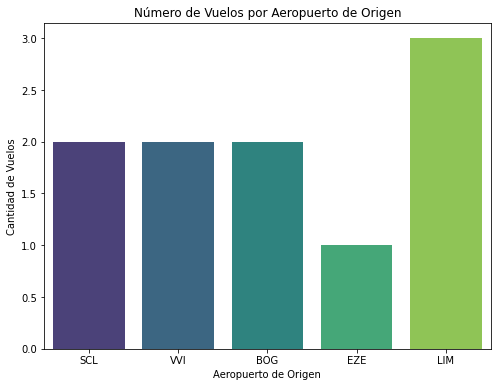

In [91]:
# 1.4: Visualización para análisis gráfico de datos generados

# Gráfico de barras: Número de vuelos por origen
plt.figure(figsize=(8, 6))
sns.countplot(data=vuelo, x='origen', palette='viridis', hue='origen', dodge=False)
plt.title('Número de Vuelos por Aeropuerto de Origen')
plt.xlabel('Aeropuerto de Origen')
plt.ylabel('Cantidad de Vuelos')
plt.legend([],[], frameon=False)
plt.show()

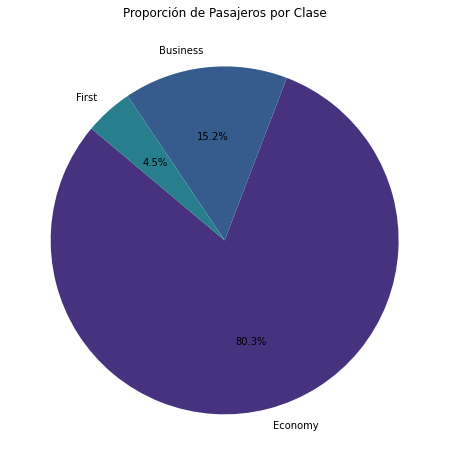

In [92]:
# Gráfico circular: Proporción de pasajeros por clase
plt.figure(figsize=(8, 8))
pasajeros_por_clase = pasajero['clase'].value_counts()
plt.pie(pasajeros_por_clase, labels=pasajeros_por_clase.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Proporción de Pasajeros por Clase')
plt.ylabel('')
plt.show()

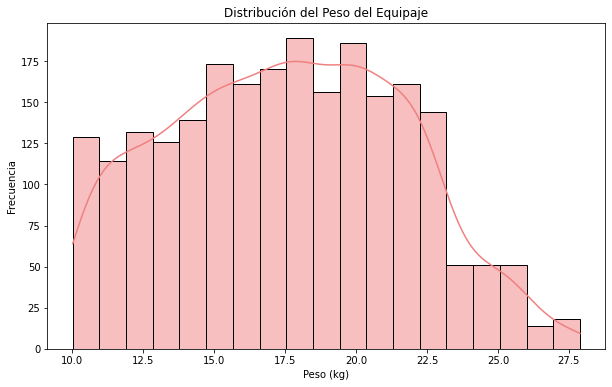

In [93]:
# Histograma: Distribución del peso del equipaje
plt.figure(figsize=(10, 6))
sns.histplot(data=equipaje, x='peso_kg', kde=True, color='lightcoral')
plt.title('Distribución del Peso del Equipaje')
plt.xlabel('Peso (kg)')
plt.ylabel('Frecuencia')
plt.show()


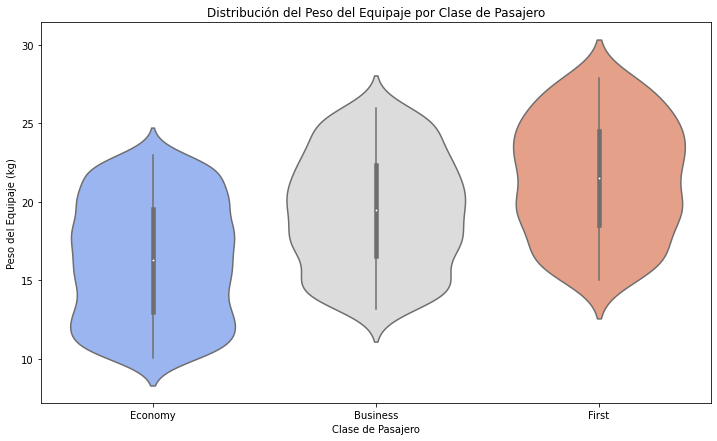

In [94]:
# Gráfico de violín: Distribución del peso del equipaje por clase de pasajero
# Para esto, necesitamos unir los dataframes de equipaje y pasajero
equipaje_con_clase_df = pd.merge(equipaje, pasajero[['pasajero_id', 'clase']], on='pasajero_id')

plt.figure(figsize=(12, 7))
sns.violinplot(data=equipaje_con_clase_df, x='clase', y='peso_kg', palette='coolwarm', order=['Economy', 'Business', 'First'])
plt.title('Distribución del Peso del Equipaje por Clase de Pasajero')
plt.xlabel('Clase de Pasajero')
plt.ylabel('Peso del Equipaje (kg)')
plt.show()

### 2: PROCESAMIENTO Y MODELO HEURÍSTICO

- Cálculo de carga de bodegas.
- Filtro de 4 horas: Se filtran los vuelos que tienen más de 4 horas hasta el despegue.
- Cálculo de capacidad restante: Se calcula el peso y volumen disponibles.
- Índice de Potencial de Carga (IPC): Heurística simple pero efectiva para priorizar vuelos.
- Priorización: Se ordenan los vuelos según su potencial de carga.
- Creación tabla principal.

In [95]:
# 2.1. Calcular la carga de equipaje actual por vuelo
carga_actual_por_vuelo = equipaje.groupby('vuelo_id').agg(peso_total_equipaje_kg=('peso_kg', 'sum'),
volumen_total_equipaje_m3=('volumen_m3', 'sum')).reset_index()

# 2.2. Unir datos de vuelos con su carga actual
analisis_vuelos_df = pd.merge(vuelo, carga_actual_por_vuelo, on='vuelo_id', how='left')
analisis_vuelos_df.fillna(0, inplace=True) # Rellenar con 0 si un vuelo aún no tiene equipaje

# 2.3. Aplicar el filtro de 4 horas de anticipación
ahora = datetime.now()
tiempo_limite = ahora + timedelta(hours=4)
vuelos_accionables_df = analisis_vuelos_df[analisis_vuelos_df['hora_salida'] > tiempo_limite].copy()

# 2.4. Calcular capacidad restante de peso y volumen
vuelos_accionables_df['peso_disponible_kg'] = (
    vuelos_accionables_df['capacidad_peso_kg'] - vuelos_accionables_df['peso_total_equipaje_kg']
).clip(lower=0) # .clip(lower=0) asegura que no haya valores negativos
vuelos_accionables_df['volumen_disponible_m3'] = (
    vuelos_accionables_df['capacidad_volumen_m3'] - vuelos_accionables_df['volumen_total_equipaje_m3']
).clip(lower=0)

# 2.5. Aplicar el modelo heurístico: Índice de Potencial de Carga (IPC), simple pero efectivo para priorizar vuelos.
# IPC = Promedio del % de capacidad disponible de peso y de volumen

vuelos_accionables_df['pct_peso_disponible'] = vuelos_accionables_df['peso_disponible_kg'] / vuelos_accionables_df['capacidad_peso_kg']
vuelos_accionables_df['pct_volumen_disponible'] = vuelos_accionables_df['volumen_disponible_m3'] / vuelos_accionables_df['capacidad_volumen_m3']
vuelos_accionables_df['ipc_score'] = (
    vuelos_accionables_df['pct_peso_disponible'] + vuelos_accionables_df['pct_volumen_disponible']
) / 2

# 2.6. Ordenar los vuelos por el IPC para priorizarlos
vuelos_priorizados_df = vuelos_accionables_df.sort_values(by='ipc_score', ascending=False)
# 2.7 Unir la información de equipaje con la de pasajeros para obtener la clase
equipaje_con_clase_df = pd.merge(equipaje,pasajero[['pasajero_id', 'clase']], on='pasajero_id',how='left')

# 2.8 Agrupar por vuelo y clase para contar el número de maletas
distribucion_equipaje = equipaje_con_clase_df.groupby(['vuelo_id', 'clase']).size().reset_index(name='numero_maletas')

# 2.9 Pivotar la tabla para tener una columna por cada clase de pasajero
analisis_distribucion_df = distribucion_equipaje.pivot_table(index='vuelo_id', columns='clase',
values='numero_maletas',fill_value=0).reset_index()

# 2.10 Unir el análisis de distribución con la tabla principal de vuelos priorizados
# Este es el paso clave: enriquecemos el dataframe principal.
vuelos_completos_df = pd.merge(vuelos_priorizados_df,analisis_distribucion_df,on='vuelo_id',how='left')
# Rellenar con 0 por si algún vuelo no tuviera equipaje registrado aún
vuelos_completos_df[['Economy', 'Business', 'First']] = vuelos_completos_df[['Economy', 'Business', 'First']].fillna(0).astype(int)

### 3: GENERACIÓN REPORTE FINAL 

In [96]:
# 3.1. Seleccionar todas las columnas deseadas para el reporte final
reporte_operaciones = vuelos_completos_df[['vuelo_id','hora_salida','destino','ipc_score','peso_disponible_kg','volumen_disponible_m3',
          'capacidad_peso_kg','capacidad_volumen_m3','Economy','Business','First']].copy()

# 3.2. Formatear las columnas numéricas y de fecha para una mejor legibilidad
reporte_operaciones['hora_salida'] = reporte_operaciones['hora_salida'].dt.strftime('%Y-%m-%d %H:%M')
reporte_operaciones['ipc_score'] = (reporte_operaciones['ipc_score'] * 100).map('{:.2f}%'.format)
reporte_operaciones['peso_disponible_kg'] = reporte_operaciones['peso_disponible_kg'].map('{:,.2f}'.format)
reporte_operaciones['volumen_disponible_m3'] = reporte_operaciones['volumen_disponible_m3'].map('{:,.2f}'.format)
reporte_operaciones['capacidad_peso_kg'] = reporte_operaciones['capacidad_peso_kg'].map('{:,.0f}'.format)
reporte_operaciones['capacidad_volumen_m3'] = reporte_operaciones['capacidad_volumen_m3'].map('{:,.0f}'.format)

# 3.3. Renombrar todas las columnas para máxima claridad en el reporte
reporte_operaciones.rename(columns={
    'vuelo_id': 'ID Vuelo',
    'hora_salida': 'Hora Salida',
    'destino': 'Destino',
    'ipc_score': 'ipc_score',
    'peso_disponible_kg': 'Peso Disponible (kg)',
    'volumen_disponible_m3': 'Volumen Disponible (m³)',
    'capacidad_peso_kg': 'Capacidad Peso (kg)',
    'capacidad_volumen_m3': 'Capacidad Volumen (m³)',
    'Economy': 'Economy',
    'Business': 'Business',
    'First': 'First'}, inplace=True)

# 3.4. Imprimir el reporte final unificado
print(f"       Reporte de Operaciones ValpoFly: Potencial y Composición de Carga de Vuelos")
print(f"       Generado el: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Vuelos ordenados por mayor potencial para agregar carga (aquellos con más de 4 horas para su salida):")
print("--------------------------------------------------------------------------------------------------------")
reporte_operaciones

       Reporte de Operaciones ValpoFly: Potencial y Composición de Carga de Vuelos
       Generado el: 2025-09-04 15:45:03
Vuelos ordenados por mayor potencial para agregar carga (aquellos con más de 4 horas para su salida):
--------------------------------------------------------------------------------------------------------


,ID Vuelo,Hora Salida,Destino,ipc_score,Peso Disponible (kg),Volumen Disponible (m³),Capacidad Peso (kg),Capacidad Volumen (m³),Economy,Business,First
0,VL_fec48a2c,2025-09-05 12:44,MIA,77.58%,"12,896.20",31.13,"15,000",45,85,24,14
1,VL_017d2661,2025-09-05 20:44,JFK,71.48%,"9,022.21",40.67,"12,000",60,97,44,27
2,VL_bf1b6860,2025-09-07 13:44,MIA,44.48%,"3,235.98",29.11,"8,000",60,163,77,26
3,VL_27d527fb,2025-09-06 16:44,MIA,43.56%,"3,849.17",17.55,"8,000",45,167,39,31
4,VL_6125dcca,2025-09-06 01:44,LAX,37.45%,"2,613.34",25.35,"8,000",60,206,60,38
5,VL_f330a599,2025-09-05 11:44,CDG,33.48%,"2,994.66",13.29,"8,000",45,194,75,11
6,VL_cd10a060,2025-09-05 07:44,LAX,28.40%,"6,815.85",0.00,"12,000",30,193,67,33
7,VL_c2564657,2025-09-06 03:44,MIA,22.05%,"3,528.23",0.00,"8,000",30,176,64,23


In [97]:
# GUARDAR ARCHIVO EN FORMATO CSV
reporte_operaciones.to_csv('reporte_operaciones.csv', index=False)

### 4: FUNCIONALIDAD ADICIONAL PARA DETECTAR EQUIPAJE REZAGADO

- Detección de equipaje rezagado: Mecanismo para identificar maletas que exceden la capacidad.

- Priorización por clase: Se prioriza la retirada de equipaje de clase Economy primero.

In [98]:
# 4.1. Configuración de funciones e impresión de tabla con informe

def detectar_vuelos_en_riesgo(vuelos_df, carga_actual_df):
    return (vuelos_df.merge(carga_actual_df, on="vuelo_id", how="left")
            .fillna(0)
            .assign(exceso_peso=lambda df: df["peso_total_equipaje_kg"] - df["capacidad_peso_kg"],
                    exceso_volumen=lambda df: df["volumen_total_equipaje_m3"] - df["capacidad_volumen_m3"])
            .query("exceso_peso > 0 or exceso_volumen > 0"))

def seleccionar_equipaje_rezagado(vuelo, equipaje_df, pasajeros_df):
    equipaje = (equipaje_df.merge(pasajeros_df[["pasajero_id", "clase"]], on="pasajero_id")
                .query("vuelo_id == @vuelo.vuelo_id")
                .assign(clase=lambda df: pd.Categorical(df["clase"],
                                categories=["First","Business","Economy"], ordered=True))
                .sort_values("clase", ascending=False))

    peso, vol = vuelo.exceso_peso, vuelo.exceso_volumen
    rezagados = []

    for _, maleta in equipaje.iterrows():
        if peso > 0 or vol > 0:
            rezagados.append(maleta)
            peso -= maleta["peso_kg"]
            vol  -= maleta["volumen_m3"]
        else:
            break
    return rezagados

def generar_reporte_rezagados(vuelos_riesgo, equipaje_df, pasajeros_df):
    rezagados = [maleta for _, vuelo in vuelos_riesgo.iterrows()
                 for maleta in seleccionar_equipaje_rezagado(vuelo, equipaje_df, pasajeros_df)]

    if not rezagados:
        print("\nNo se detectó sobrecarga de equipaje en ningún vuelo.")
        return

    df = (pd.DataFrame(rezagados)
          .merge(vuelos_riesgo[["vuelo_id","destino"]], on="vuelo_id", how="left")
          .rename(columns={"vuelo_id":"Vuelo", "destino":"Destino",
                           "equipaje_id":"ID Equipaje","pasajero_id":"ID Pasajero",
                           "clase":"Clase","peso_kg":"Peso (kg)","volumen_m3":"Volumen (m³)"}))

    print("\nALERTA DE EQUIPAJE REZAGADO")
    print(f"Generado: {datetime.now():%Y-%m-%d %H:%M:%S}\n")
    print("El siguiente equipaje no puede ser embarcado y debe ser gestionado:")
    print("--------------------------------------------------------------------------------------")
    print(df.to_string(index=False))

# Ejecución
vuelos_riesgo = detectar_vuelos_en_riesgo(vuelo, carga_actual_por_vuelo)
generar_reporte_rezagados(vuelos_riesgo, equipaje, pasajero)


ALERTA DE EQUIPAJE REZAGADO
Generado: 2025-09-04 15:45:12

El siguiente equipaje no puede ser embarcado y debe ser gestionado:
--------------------------------------------------------------------------------------
    ID Equipaje    ID Pasajero       Vuelo  Peso (kg)  Volumen (m³)   Clase Destino
EQ_4b265132fe5f PAX_1b563c7af2 VL_c2564657      13.64        0.1180 Economy     MIA
EQ_b03580c0df64 PAX_5264d1e9a9 VL_c2564657      11.21        0.1052 Economy     MIA
EQ_24147518ab1d PAX_733503f0d4 VL_c2564657      21.30        0.1393 Economy     MIA
EQ_386381b4e6d0 PAX_f3ff427d23 VL_c2564657      22.04        0.1075 Economy     MIA
EQ_6c5959178c89 PAX_32a3e11ca3 VL_c2564657      11.70        0.1004 Economy     MIA
EQ_01988bd4f75a PAX_a9a3d6f061 VL_c2564657      17.69        0.0844 Economy     MIA
EQ_8027270cabd3 PAX_8c1de4ff45 VL_c2564657      20.25        0.1426 Economy     MIA
EQ_ca2970c531a7 PAX_579bad0782 VL_cd10a060      19.39        0.1081 Economy     LAX
EQ_c424472416a6 PAX_98ebf6b94

### Breve análisis sobre cómo mejoraría el prototipo en un entorno real.

El prototipo generado, basado en el "Índice de Potencial de Carga (IPC)", ha demostrado ser una base funcional y una prueba de concepto exitosa para abordar el desafío de optimización de bodegas en ValpoFly. Su enfoque heurístico es simple, interpretable y efectivo para una primera etapa. Sin embargo, para transformar este prototipo en una herramienta estratégica de alto impacto, es crucial pensar en qué herramientas y técnicas potenciarían este marco conceptual para ponerlo en producción en un ambito real.

Se consideraría inicialmente:

- Reemplazar los datos sintéticos con conexiones directas a las bases de datos operacionales de la compañía (SQL, NoSQL).


- Al entregar resultados 4 horas antes de cada vuelo, el script debe ser orquestado para su ejecución periódica.


- Para subir el nivel de procesamiento y valor, pensar en implementar un modelo de Machine Learning. En lugar de solo reaccionar a la carga ya registrada, un modelo predictivo podría estimar el peso y volumen final del equipaje basándose en datos históricos. 


- Para mejor presentación al equipo, implementar interfaces visuales para facilitar la toma de decisiones operativas.